In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import scipy.stats as stats
from sklearn.preprocessing import RobustScaler, LabelBinarizer, label_binarize
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, log_loss, classification_report, confusion_matrix, ConfusionMatrixDisplay,make_scorer
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.stats import ks_2samp, entropy
from imblearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
X_train = pd.read_csv("data/X_train.csv")
y_train = pd.read_csv("data/y_train.csv")
X_test_1 = pd.read_csv("data/X_test_1.csv")
X_test_2 = pd.read_csv("data/X_test_2.csv")
y_test_2_reduced = pd.read_csv("data/y_test_2_reduced.csv")

In [3]:
def winsorize_iqr(df, lower=1.5, upper=1.5):
    """
    Apply IQR-based winsorization to cap outliers in each feature column.

    This method clips each feature's values to lie within the range:
        [Q1 - lower * IQR, Q3 + upper * IQR],
    where Q1 and Q3 are the 25th and 75th percentiles, respectively, and
    IQR = Q3 - Q1.

    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe with numeric feature columns.
    lower : float, default=1.5
        Lower bound multiplier for the IQR range (used to define minimum threshold).
    upper : float, default=1.5
        Upper bound multiplier for the IQR range (used to define maximum threshold).

    Returns:
    --------
    pd.DataFrame
        A new DataFrame with outlier values capped using IQR method.
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame")

    df_capped = df.copy()
    for col in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - lower * IQR
        upper_bound = Q3 + upper * IQR

        df_capped[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

    return df_capped
# === 2. 定义 iOR 打分函数 ===
def compute_ior(X, y):
    """
    Improved Odds Ratio (iOR) Feature Scoring Function.
    For each feature, computes the class-wise standardized mean difference (SMD),
    which is inspired by the Fisher Score and Cohen's d effect size.

    Parameters:
    -----------
    X : pd.DataFrame of shape (n_samples, n_features)
        Feature matrix (after preprocessing, e.g., winsorization, scaling)
    y : pd.Series of shape (n_samples,)
        Target labels (multi-class)

    Returns:
    --------
    np.ndarray of shape (n_features,)
        iOR score for each feature
    """
    y_arr = y.values.ravel()
    classes = np.unique(y_arr)
    scores = []

    for j in range(X.shape[1]):
        feat = X.iloc[:, j]
        score = 0.0
        for c in classes:
            pos = feat[y_arr == c]
            neg = feat[y_arr != c]

            μ1 = pos.mean() if len(pos) > 0 else 0
            μ0 = neg.mean() if len(neg) > 0 else 0
            σ1 = pos.std()
            σ0 = neg.std()

            # 防止标准差为0
            if σ1 == 0: σ1 = 1
            if σ0 == 0: σ0 = 1

            score += abs((μ1 - μ0) / (σ1 + σ0))
        scores.append(score)

    return np.array(scores)

In [ ]:
# Covariate shift

X_train 和 X_test_1 的 300 个特征中，其中 113 个特征（约 37.67%）发生了协变量偏移。


,Feature,KS_statistic,p_value,KL_divergence,Shift_flag
48,48,0.0691,0.000325,0.108640,True
125,125,0.0688,0.000350,0.056756,False
253,253,0.0679,0.000438,0.068163,False
270,270,0.0664,0.000633,0.071281,True
90,90,0.0656,0.000768,0.056961,False


X_train 和 X_test_2 的 300 个特征中，其中 150 个特征（约 50.00%）发生了协变量偏移。


,Feature,KS_statistic,p_value,KL_divergence,Shift_flag
90,90,0.297888,2.497427e-132,0.283712,True
249,249,0.290921,3.967352e-126,0.269756,True
141,141,0.274818,2.143881e-112,0.234486,True
86,86,0.272148,3.373654e-110,0.307346,True
111,111,0.263647,2.348210e-103,0.250430,True


/tmp/ipykernel_5126/2583460031.py:53: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train[feature_name], label="Train", shade=True)
/tmp/ipykernel_5126/2583460031.py:54: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test[feature_name], label="Test", shade=True)


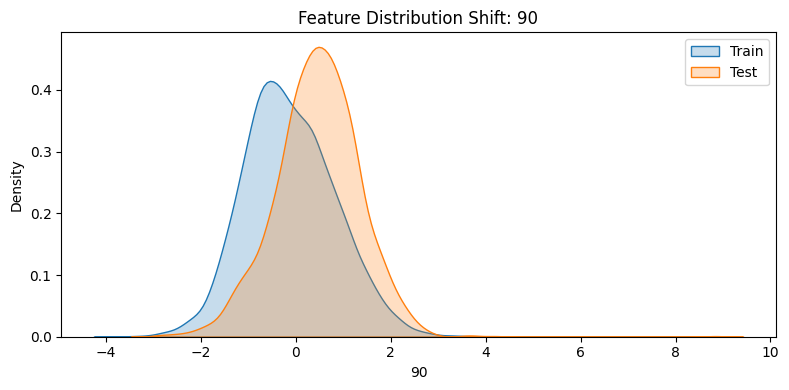

In [6]:
# === KS + KL 检验函数 ===
def check_covariate_shift_ks_kl(X_train, X_test, alpha=0.05, kl_threshold=0.07, ks_threshold=0.1):
    ks_results = []

    for col in X_train.columns:
        # KS检验
        stat, p_value = ks_2samp(X_train[col], X_test[col])

        # KL散度：构建直方图估计概率密度
        train_hist, bins = np.histogram(X_train[col], bins=50, range=(X_train[col].min(), X_train[col].max()), density=True)
        test_hist, _ = np.histogram(X_test[col], bins=bins, density=True)

        # 平滑处理避免除0
        train_hist += 1e-8
        test_hist += 1e-8

        kl_div = entropy(train_hist, test_hist)

        # 是否检测到协变量漂移（组合判断）
        shift_flag = (stat > ks_threshold and p_value < alpha) or (kl_div > kl_threshold)

        ks_results.append({
            "Feature": col,
            "KS_statistic": stat,
            "p_value": p_value,
            "KL_divergence": kl_div,
            "Shift_flag": shift_flag
        })

    return pd.DataFrame(ks_results).sort_values("KS_statistic", ascending=False)

# === 应用在 X_test_1 ===
result_df_1 = check_covariate_shift_ks_kl(X_train, X_test_1)
n_total_1 = len(result_df_1)
n_shift_1 = result_df_1['Shift_flag'].sum()
shift_ratio_1 = n_shift_1 / n_total_1

print(f"X_train 和 X_test_1 的 {n_total_1} 个特征中，其中 {n_shift_1} 个特征（约 {shift_ratio_1:.2%}）发生了协变量偏移。")
display(result_df_1.head())

# === 应用在 X_test_2 ===
result_df_2 = check_covariate_shift_ks_kl(X_train, X_test_2)
n_total_2 = len(result_df_2)
n_shift_2 = result_df_2['Shift_flag'].sum()
shift_ratio_2 = n_shift_2 / n_total_2

print(f"X_train 和 X_test_2 的 {n_total_2} 个特征中，其中 {n_shift_2} 个特征（约 {shift_ratio_2:.2%}）发生了协变量偏移。")
display(result_df_2.head())

# === 可视化函数 ===
def plot_feature_shift(X_train, X_test, feature_name):
    plt.figure(figsize=(8, 4))
    sns.kdeplot(X_train[feature_name], label="Train", shade=True)
    sns.kdeplot(X_test[feature_name], label="Test", shade=True)
    plt.title(f"Feature Distribution Shift: {feature_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()

# 示例：可视化第90列的分布变化
plot_feature_shift(X_train, X_test_2, '90')

    Feature  KS_statistic   p_value  shift_detected
48       48        0.0691  0.000325            True
125     125        0.0688  0.000350            True
253     253        0.0679  0.000438            True
270     270        0.0664  0.000633            True
90       90        0.0656  0.000768            True
..      ...           ...       ...             ...
118     118        0.0169  0.954319           False
137     137        0.0153  0.981787           False
109     109        0.0151  0.984123           False
202     202        0.0142  0.992077           False
59       59        0.0142  0.992077           False

[300 rows x 4 columns]
X_train 和 X_test_1 的 300 个特征中，其中 63 个特征（约 21.00%）在训练集与测试集之间发生了显著分布偏移（p < 0.05），存在协变量偏移的风险。
    Feature  KS_statistic       p_value  shift_detected
249     249      0.252515  5.690025e-38            True
90       90      0.247891  1.351822e-36            True
111     111      0.245158  8.541885e-36            True
141     141      0.233703  1.539268e-

/tmp/ipykernel_5126/1737749648.py:34: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train[feature_name], label="Train", shade=True)
/tmp/ipykernel_5126/1737749648.py:35: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test[feature_name], label="Test", shade=True)


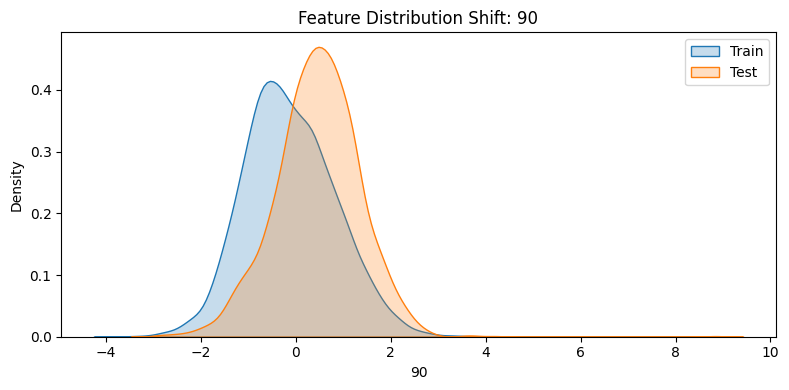

In [7]:
# 逐列执行 KS 检验
def check_covariate_shift_ks(X_train, X_test, alpha=0.05):
    ks_results = []

    for col in X_train.columns:
        stat, p = ks_2samp(X_train[col], X_test[col])
        ks_results.append({
            "Feature": col,
            "KS_statistic": stat,
            "p_value": p,
            "shift_detected": p < alpha
        })

    return pd.DataFrame(ks_results).sort_values("KS_statistic", ascending=False)

result_df = check_covariate_shift_ks(X_train, X_test_1)
print(result_df)
n_total = len(result_df)
n_shift = result_df['shift_detected'].sum()
shift_ratio = n_shift / n_total

print(f"X_train 和 X_test_1 的 {n_total} 个特征中，其中 {n_shift} 个特征（约 {shift_ratio:.2%}）在训练集与测试集之间发生了显著分布偏移（p < 0.05），存在协变量偏移的风险。")

result_df_2 = check_covariate_shift_ks(X_test_1, X_test_2)
print(result_df_2)
n_total_2 = len(result_df_2)
n_shift_2 = result_df_2['shift_detected'].sum()
shift_ratio_2 = n_shift_2 / n_total_2

print(f"X_test_1 和 X_test_2 的 {n_total_2} 个特征中，其中 {n_shift_2} 个特征（约 {shift_ratio_2:.2%}）在训练集与测试集之间发生了显著分布偏移（p < 0.05），存在协变量偏移的风险。")

def plot_feature_shift(X_train, X_test, feature_name):
    plt.figure(figsize=(8, 4))
    sns.kdeplot(X_train[feature_name], label="Train", shade=True)
    sns.kdeplot(X_test[feature_name], label="Test", shade=True)
    plt.title(f"Feature Distribution Shift: {feature_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
plot_feature_shift(X_train, X_test_2, '90')

In [ ]:
# Label shift


=== Label Shift Analysis ===
       Train_P(Y)  Test_P(Y)     Shift
Label                                 
0          0.0018   0.000000  0.001800
1          0.0007   0.000000  0.000700
2          0.0007   0.004950  0.004250
3          0.0065   0.004950  0.001550
4          0.0238   0.019802  0.003998
5          0.4479   0.044554  0.403346
6          0.0553   0.014851  0.040449
7          0.0103   0.069307  0.059007
8          0.0516   0.143564  0.091964
9          0.0025   0.014851  0.012351
10         0.1081   0.009901  0.098199
11         0.0078   0.044554  0.036754
12         0.0457   0.212871  0.167171
13         0.0062   0.004950  0.001250
14         0.0264   0.029703  0.003303
15         0.0026   0.004950  0.002350
16         0.0006   0.000000  0.000600
17         0.0354   0.049505  0.014105
18         0.0060   0.004950  0.001050
19         0.0177   0.019802  0.002102
20         0.0153   0.014851  0.000449
21         0.0269   0.034653  0.007753
22         0.0007   0.000000  0.00

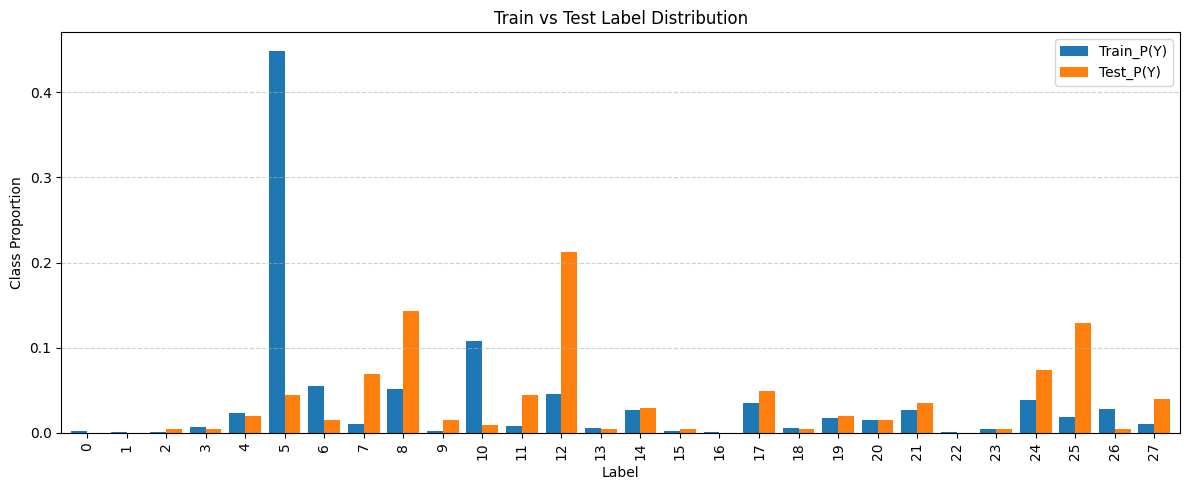

,Label,Train_P(Y),Test_P(Y),Shift
0,0,0.0018,0.000000,0.001800
1,1,0.0007,0.000000,0.000700
2,2,0.0007,0.004950,0.004250
3,3,0.0065,0.004950,0.001550
4,4,0.0238,0.019802,0.003998
5,5,0.4479,0.044554,0.403346
6,6,0.0553,0.014851,0.040449
7,7,0.0103,0.069307,0.059007
8,8,0.0516,0.143564,0.091964
9,9,0.0025,0.014851,0.012351


In [8]:
def check_label_shift(y_train, y_test):
    # 保证是 Series 类型
    if isinstance(y_train, pd.DataFrame):
        y_train = y_train.iloc[:, 0]
    if isinstance(y_test, pd.DataFrame):
        y_test = y_test.iloc[:, 0]

    # 标签全集
    all_labels = sorted(set(y_train.unique()) | set(y_test.unique()))

    # 归一化频率
    y_train_counts = y_train.value_counts(normalize=True).sort_index()
    y_test_counts = y_test.value_counts(normalize=True).sort_index()

    # 构建概率向量（对所有标签补齐）
    train_probs = np.array([y_train_counts.get(i, 0) for i in all_labels])
    test_probs = np.array([y_test_counts.get(i, 0) for i in all_labels])

    label_df = pd.DataFrame({
        "Label": all_labels,
        "Train_P(Y)": train_probs,
        "Test_P(Y)": test_probs
    })

    # 平均偏移
    label_df["Shift"] = abs(label_df["Train_P(Y)"] - label_df["Test_P(Y)"])
    avg_shift = label_df["Shift"].mean()

    # KL 散度（加平滑避免除0）
    train_probs_smooth = train_probs + 1e-8
    test_probs_smooth = test_probs + 1e-8
    kl_div = entropy(test_probs_smooth, train_probs_smooth)

    # 打印结果
    print("\n=== Label Shift Analysis ===")
    print(label_df.set_index("Label"))

    print(f"\n平均标签偏移程度: {avg_shift:.2%}")
    print(f"KL 散度（KL Divergence）: {kl_div:.4f}")

    # 可视化
    label_df.set_index("Label")[["Train_P(Y)", "Test_P(Y)"]].plot.bar(figsize=(12, 5), width=0.8)
    plt.title("Train vs Test Label Distribution")
    plt.ylabel("Class Proportion")
    plt.xlabel("Label")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    return label_df

check_label_shift(y_train, y_test_2_reduced)

In [ ]:
# 4.3 Concept Shift

In [10]:
# === 0. 划分训练子集与验证集 ===
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# === 1. 离群值裁剪（IQR）===
X_train_sub_capped = winsorize_iqr(X_train_sub)
X_val_capped = winsorize_iqr(X_val)

# === 2. 鲁棒缩放 ===
scaler = RobustScaler()
X_train_sub_scaled = pd.DataFrame(scaler.fit_transform(X_train_sub_capped), columns=X_train_sub.columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val_capped), columns=X_val.columns)

# === 3. 使用 SelectKBest(f_classif) 进行特征打分与选择 ===
k = 270  # 设置选择的特征数量
selector = SelectKBest(score_func=f_classif, k=k)
selector.fit(X_train_sub_scaled, y_train_sub.values.ravel())

# === 4. 获取每个特征的 F 分数和 p 值 ===
f_scores = selector.scores_
p_values = selector.pvalues_

# === 5. 构建特征打分表 ===
feature_scores_df = pd.DataFrame({
    'Feature': X_train_sub_scaled.columns,
    'F_score': f_scores,
    'p_value': p_values
}).sort_values(by='F_score', ascending=False).reset_index(drop=True)

# === 6. 选出 Top-K 特征列名 ===
top_features_df = feature_scores_df.head(k)
selected_columns = top_features_df['Feature'].tolist()

# === 7. 筛选子训练集和验证集特征列 ===
X_train_ftest = X_train_sub_scaled[selected_columns]
X_val_ftest = X_val_scaled[selected_columns]

# === 8. 打印结果 ===
print(f"Top {k} Features by F-test (ANOVA F-test) from validation set:")
print(top_features_df)

Top 270 Features by F-test (ANOVA F-test) from validation set:
    Feature     F_score       p_value
0        48  258.029213  0.000000e+00
1        17  231.333457  0.000000e+00
2       263  219.405359  0.000000e+00
3       270  218.617485  0.000000e+00
4        90  200.600021  0.000000e+00
..      ...         ...           ...
265     225   17.858959  3.939549e-82
266     289   17.798027  8.221130e-82
267      32   17.350174  1.833181e-79
268      66   17.212820  9.625267e-79
269     165   17.060832  6.030342e-78

[270 rows x 3 columns]


In [12]:
# ==== 1. IQR 裁剪函数 ====
def winsorize_iqr(df, lower=1.5, upper=1.5):
    df_capped = df.copy()
    for col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - lower * IQR
        upper_bound = Q3 + upper * IQR
        df_capped[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    return df_capped

# ==== 2. 自定义加权 log loss ====
def weighted_log_loss(y_true, y_pred_proba):
    """
    修复后的 Weighted Log Loss 函数，仅使用真实标签中出现的类别，避免维度错位导致的全 0 问题。
    
    参数：
    - y_true: 一维 array，真实标签
    - y_pred_proba: 二维 array，预测的概率分布，形状为 (n_samples, n_classes)
    
    返回：
    - 修正后的加权 log loss 值
    """

    # 1. 找出 y_true 中实际出现的类别（注意是已排序的 subset）
    present_classes = np.unique(y_true)

    # 2. 限定预测概率只保留这些列
    y_pred_proba_sub = y_pred_proba[:, present_classes]

    # 3. 重新 label_binarize
    y_true_bin = label_binarize(y_true, classes=present_classes)

    # 4. 计算每个类别的权重（类别越少，权重越大）
    class_counts = np.sum(y_true_bin, axis=0)
    class_weights = 1.0 / (class_counts + 1e-8)
    class_weights /= np.sum(class_weights)

    # 5. 计算每个样本的权重 + log loss
    sample_weights = np.sum(y_true_bin * class_weights, axis=1)
    sample_losses = -np.sum(y_true_bin * np.log(y_pred_proba_sub + 1e-8), axis=1)

    # 6. 返回加权平均损失
    return np.mean(sample_weights * sample_losses)

# ==== 3. 训练集预处理 ====
X_train_clean = winsorize_iqr(X_train_ftest)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_clean)

# ==== 4. 测试集预处理 ====
# 假设你原来训练用的是 X_train_fisher = X_train[feature_cols]，现在需要拿同样的列来处理测试集：
X_test_fisher = X_test_2[ X_train_ftest.columns ].iloc[:len(y_test_2_reduced)].copy()

# 然后照常进行 IQR + Scaling
X_test_clean = winsorize_iqr(X_test_fisher)
X_test_scaled = scaler.transform(X_test_clean)
X_test_clean.columns = X_train_clean.columns  
X_test_scaled = scaler.transform(X_test_clean)
y_test_array = y_test_2_reduced.values.ravel()

final_model = XGBClassifier()
final_model.load_model("final_model_1.json")

# ==== 5. 用 final_model 预测测试集 ====
y_test_pred = final_model.predict(X_test_scaled)
y_test_proba = final_model.predict_proba(X_test_scaled)

# ==== 6. 计算新数据上的指标 ====
print("\n=== 新数据集评估结果（测试集） ===")
print(classification_report(y_test_array, y_test_pred, zero_division=0))
print(f"Accuracy:           {accuracy_score(y_test_array, y_test_pred):.4f}")
print(f"F1 Macro:           {f1_score(y_test_array, y_test_pred, average='macro'):.4f}")
print(f"F1 Weighted:        {f1_score(y_test_array, y_test_pred, average='weighted'):.4f}")
print(f"Log Loss:           {log_loss(y_test_array, y_test_proba, labels=np.arange(28)):.4f}")
print(f"Weighted Log Loss:  {weighted_log_loss(y_test_array, y_test_proba):.4f}")


=== 新数据集评估结果（测试集） ===
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.43      0.75      0.55         4
           5       0.32      0.89      0.47         9
           6       0.50      1.00      0.67         3
           7       0.83      0.36      0.50        14
           8       0.81      0.76      0.79        29
           9       0.00      0.00      0.00         3
          10       0.09      1.00      0.16         2
          11       0.89      0.89      0.89         9
          12       0.82      0.72      0.77        43
          13       0.33      1.00      0.50         1
          14       0.00      0.00      0.00         6
          15       0.00      0.00      0.00         1
          17       0.86      0.60      0.71        10
          18       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         4
    

In [ ]:
# 解决措施

In [13]:
# === 自定义加权 log loss（只针对真实出现的类别） ===
def weighted_log_loss(y_true, y_pred_proba):
    present_classes = np.sort(np.unique(y_true))
    y_true_bin = label_binarize(y_true, classes=present_classes)
    y_proba_sub = y_pred_proba[:, present_classes]

    class_counts = np.sum(y_true_bin, axis=0)
    class_weights = 1.0 / (class_counts + 1e-8)
    class_weights /= np.sum(class_weights)

    sample_weights = np.sum(y_true_bin * class_weights, axis=1)
    sample_losses  = -np.sum(y_true_bin * np.log(y_proba_sub + 1e-8), axis=1)
    return np.mean(sample_weights * sample_losses)

# ========== 1. 对齐测试集行数 ==========
min_len = min(len(X_test_2), len(y_test_2_reduced))
X_test2 = X_test_2.iloc[:min_len].reset_index(drop=True)
y_test2 = y_test_2_reduced.iloc[:min_len].reset_index(drop=True)

# ========== 2. 初始训练并评估（全部测试集） ==========
model = XGBClassifier(use_label_encoder=False,
                      eval_metric='mlogloss',
                      random_state=42)
model.fit(X_train, y_train)

y_pred_full  = model.predict(X_test2)
y_proba_full = model.predict_proba(X_test2)

present = np.sort(np.unique(y_test2))
y_proba_full_sub = y_proba_full[:, present]

print("=== 初始模型评估（全部 X_test_2） ===")
print(f"Accuracy:           {accuracy_score(y_test2, y_pred_full):.4f}")
print(f"F1 Macro:           {f1_score(y_test2, y_pred_full, average='macro'):.4f}")
print(f"F1 Weighted:        {f1_score(y_test2, y_pred_full, average='weighted'):.4f}")
print(f"Log Loss:           {log_loss(y_test2, y_proba_full_sub, labels=present):.4f}")
print(f"Weighted Log Loss:  {weighted_log_loss(y_test2, y_proba_full):.4f}")

# ========== 3. 构造“分布漂移”实验集 ==========
n = min_len // 2
X_shift_train = pd.concat([X_train, X_test2.iloc[:n]], axis=0).reset_index(drop=True)
y_shift_train = pd.concat([y_train, y_test2.iloc[:n]], axis=0).reset_index(drop=True)

X_shift_test  = X_test2.iloc[n:].reset_index(drop=True)
y_shift_test  = y_test2.iloc[n:].reset_index(drop=True)

# ========== 4. 再次训练并评估后半部分测试集 ==========
model_shift = XGBClassifier(use_label_encoder=False,
                            eval_metric='mlogloss',
                            random_state=42)
model_shift.fit(X_shift_train, y_shift_train)

y_pred_shift      = model_shift.predict(X_shift_test)
y_proba_shift_all = model_shift.predict_proba(X_shift_test)

present_shift = np.sort(np.unique(y_shift_test))
y_proba_shift = y_proba_shift_all[:, present_shift]

print("\n=== 分布漂移后模型评估（后半部分 X_test_2） ===")
print(f"Accuracy:           {accuracy_score(y_shift_test, y_pred_shift):.4f}")
print(f"F1 Macro:           {f1_score(y_shift_test, y_pred_shift, average='macro'):.4f}")
print(f"F1 Weighted:        {f1_score(y_shift_test, y_pred_shift, average='weighted'):.4f}")
print(f"Log Loss:           {log_loss(y_shift_test, y_proba_shift, labels=present_shift):.4f}")
print(f"Weighted Log Loss:  {weighted_log_loss(y_shift_test, y_proba_shift_all):.4f}")

/root/miniconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:23:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== 初始模型评估（全部 X_test_2） ===
Accuracy:           0.5644
F1 Macro:           0.3858
F1 Weighted:        0.5719
Log Loss:           1.7851
Weighted Log Loss:  0.0316


/root/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/root/miniconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:23:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== 分布漂移后模型评估（后半部分 X_test_2） ===
Accuracy:           0.6139
F1 Macro:           0.4390
F1 Weighted:        0.6461
Log Loss:           1.6990
Weighted Log Loss:  0.0402


/root/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


In [ ]:
# 重新进行特征选择， 模型超参数调参

In [4]:
# 保证只取前 202 行（与标签对齐）
X_test_2_subset = X_test_2.iloc[:len(y_test_2_reduced)].copy()

# 拼接特征和标签
X_train_2_new = pd.concat([X_train, X_test_2_subset], axis=0).reset_index(drop=True)
y_train_2_new = pd.concat([y_train, y_test_2_reduced], axis=0).reset_index(drop=True)
X_train=X_train_2_new
y_train = y_train_2_new

In [16]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.617940,-0.391980,0.13278,0.032551,0.552010,0.83393,-0.837550,-0.87406,0.43930,0.26826,...,-0.45454,0.36452,1.57530,-0.620320,-0.253710,-0.44775,-0.038273,-0.019938,-0.195500,0.428830
1,0.333860,-1.549100,1.67050,0.793560,0.802510,-0.07206,-0.068276,3.30240,0.52045,0.68572,...,-0.36913,1.74080,1.28660,-0.013396,-1.539300,0.83354,0.472610,0.513030,-0.743140,1.219900
2,0.040399,-0.608070,1.62080,-0.355970,0.121050,1.35250,0.373200,1.11170,0.35894,-0.34410,...,-1.40230,-0.24763,0.50705,0.708220,-0.600830,0.91104,0.009979,-0.475990,-0.094731,-0.008521
3,1.723600,0.195290,1.03880,-3.009100,-0.332220,0.91067,0.666690,0.71725,3.05850,1.48990,...,-1.21540,-0.25284,-1.30780,-0.445660,0.279180,0.26467,-0.149360,1.492900,-1.176700,-1.854500
4,-1.032300,1.900100,-1.46010,0.383710,-0.510390,0.74481,-0.914660,-0.86588,-0.34426,0.86965,...,1.32230,0.06020,-1.07900,-0.617050,1.184500,-0.21063,-0.105870,-0.412040,1.409700,0.133350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10197,-1.251700,1.248800,-0.56923,0.312230,-0.144020,0.21581,1.504400,-1.81130,-1.65760,-0.32030,...,0.58130,-0.95760,0.11628,-0.040421,0.905790,0.34242,0.041975,-1.100400,-0.797670,0.398550
10198,0.288050,-1.002900,-0.46950,-1.368300,1.822900,0.31026,-0.268550,-0.65032,-0.55683,-0.69601,...,1.56950,0.10581,0.23206,-0.430860,0.138470,-0.27510,0.628940,-0.245780,1.123200,0.053514
10199,-0.613220,0.990720,0.17853,1.036200,0.057115,-1.61470,-1.631000,0.53872,0.36720,1.31570,...,-0.72542,0.39775,-1.43480,-0.740550,-0.057339,0.75160,-1.842500,-1.686000,0.359590,-1.050600
10200,-0.518580,-0.007953,-1.31170,0.129180,-1.144400,-0.32682,-0.612040,-0.37912,0.46488,0.48437,...,0.24322,-1.00340,-0.12906,-0.413630,0.340030,1.81650,-0.397150,-0.150920,1.642200,-1.200300


In [17]:
y_train

,label
0,10
1,5
2,5
3,5
4,5
...,...
10197,12
10198,8
10199,27
10200,18


In [ ]:
# Feature Selection

In [ ]:
# IOR 

Evaluating top-K: 100%|██████████| 300/300 [13:00<00:00,  2.60s/it]


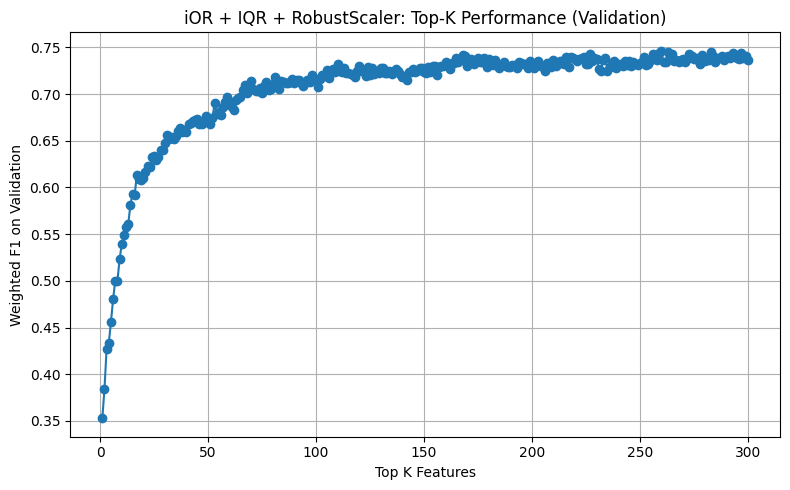


The best k = 260, and its Weighted F1-score on val dataset is 0.7464


In [19]:
# === 0. 划分子训练集 & 验证集（从原始训练集中抽出 20% 作为验证集） ===
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# === 3. 对子训练集 & 验证集同时做 IQR + RobustScaler ===
X_tr_capped = winsorize_iqr(X_train_sub)
X_val_capped = winsorize_iqr(X_val)

scaler = RobustScaler()
X_tr_scaled  = pd.DataFrame(scaler.fit_transform(X_tr_capped),
                            columns=X_tr_capped.columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val_capped),
                            columns=X_val_capped.columns)

# === 4. iOR 排序 + Top‑K 特征选择 & 验证集评估 ===
ior_scores   = compute_ior(X_tr_scaled, y_train_sub)
feature_rank = np.argsort(ior_scores)[::-1]

k_list  = list(range(1,301))
results = []

for k in tqdm(k_list, desc="Evaluating top-K"):
    cols_k   = X_tr_scaled.columns[feature_rank[:k]]
    Xk_tr    = X_tr_scaled[cols_k]
    Xk_val   = X_val_scaled[cols_k]

    model = XGBClassifier(
        objective='multi:softprob',
        num_class=28,
        eval_metric='mlogloss',
        n_estimators=100,
        random_state=42,
        tree_method='hist',
        device='cuda'
    )
    model.fit(Xk_tr, y_train_sub.values.ravel())
    y_pred = model.predict(Xk_val)

    f1 = f1_score(y_val, y_pred, average='weighted')
    results.append((k, f1))

# === 5. 可视化 Top‑K vs F1 曲线 ===
ks, f1s = zip(*results)
plt.figure(figsize=(8,5))
plt.plot(ks, f1s, marker='o')
plt.xlabel("Top K Features")
plt.ylabel("Weighted F1 on Validation")
plt.title("iOR + IQR + RobustScaler: Top-K Performance (Validation)")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 6. 输出最优 k & F1 ===
best_k, best_f1 = max(results, key=lambda x: x[1])
print(f"\nThe best k = {best_k}, and its Weighted F1-score on val dataset is {best_f1:.4f}")

In [5]:
# === 0. 划分训练集与验证集 ===
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# === 1. IQR 裁剪 ===
X_train_sub_capped = winsorize_iqr(X_train_sub)
X_val_capped = winsorize_iqr(X_val)

# === 2. 鲁棒缩放 ===
scaler = RobustScaler()
X_train_sub_scaled = pd.DataFrame(scaler.fit_transform(X_train_sub_capped), columns=X_train_sub.columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val_capped), columns=X_val.columns)

# === 3. 计算 iOR 分数（仅用子训练集）===
ior_scores = compute_ior(X_train_sub_scaled, y_train_sub)

# === 4. 构建 iOR 排名表 ===
ior_df = pd.DataFrame({
    'Feature': X_train_sub_scaled.columns,
    'iOR_score': ior_scores
}).sort_values(by='iOR_score', ascending=False).reset_index(drop=True)

# === 5. 设置最佳特征数量（使用前面验证得到的 k）===
k = 260
top_features_df = ior_df.head(k)
selected_columns = top_features_df['Feature'].tolist()

# === 6. 筛选特征（子训练集 & 验证集）===
X_train_selected = X_train_sub_scaled[selected_columns]
X_val_selected = X_val_scaled[selected_columns]

# === 7. 打印 Top‑K 特征 ===
print(f"Top {k} Features by improved Odds Ratio (iOR) from validation set:")
print(top_features_df)

Top 260 Features by improved Odds Ratio (iOR) from validation set:
    Feature  iOR_score
0       270  12.295900
1        90  11.882501
2        17  11.386964
3       218  11.291448
4       111  11.187706
..      ...        ...
255      82   4.483097
256     297   4.454953
257     267   4.452102
258     195   4.416752
259     199   4.399477

[260 rows x 2 columns]


In [ ]:
# SelectKBest

Evaluating SelectKBest(f_classif) on val: 100%|██████████| 300/300 [12:49<00:00,  2.57s/it]


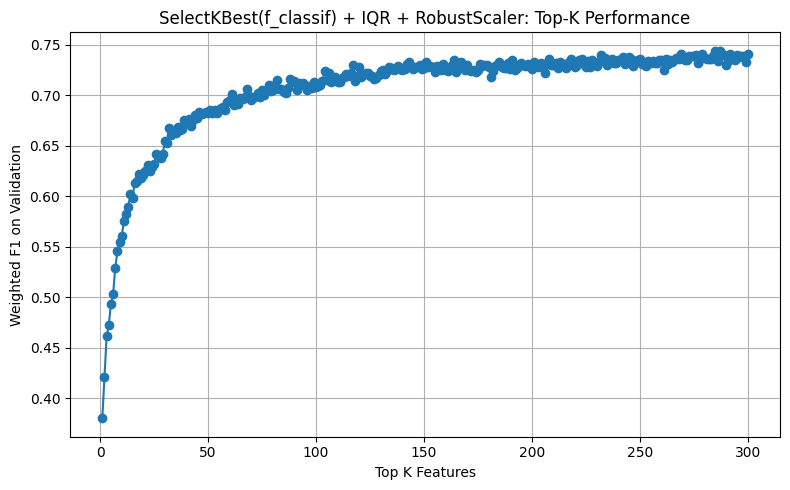


 The best k = 285, and its Weighted F1-score on validation set is 0.7441


In [21]:
# === Step 0: 划分子训练集与验证集 ===
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# === Step 1: 离群值裁剪（IQR）===
X_train_sub_capped = winsorize_iqr(X_train_sub)
X_val_capped = winsorize_iqr(X_val)

# === Step 2: 鲁棒标准化（RobustScaler）===
scaler = RobustScaler()
X_train_sub_scaled = pd.DataFrame(scaler.fit_transform(X_train_sub_capped),
                                  columns=X_train_sub.columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val_capped),
                            columns=X_val.columns)

# === Step 3: 特征选择 + 验证集评估 ===
k_list = list(range(1, 301))
results = []

for k in tqdm(k_list, desc="Evaluating SelectKBest(f_classif) on val"):
    selector = SelectKBest(score_func=f_classif, k=k)
    Xk_train = selector.fit_transform(X_train_sub_scaled, y_train_sub.values.ravel())
    Xk_val   = selector.transform(X_val_scaled)

    model = XGBClassifier(
        objective='multi:softprob',
        num_class=28,
        eval_metric='mlogloss',
        n_estimators=100,
        random_state=42,
        tree_method='hist',
        device='cuda'
    )
    model.fit(Xk_train, y_train_sub.values.ravel())
    y_pred = model.predict(Xk_val)

    f1 = f1_score(y_val, y_pred, average='weighted')
    results.append((k, f1))

# === Step 4: 可视化 Top‑K vs 验证集 F1 ===
ks, f1s = zip(*results)
plt.figure(figsize=(8, 5))
plt.plot(ks, f1s, marker='o')
plt.xlabel("Top K Features")
plt.ylabel("Weighted F1 on Validation")
plt.title("SelectKBest(f_classif) + IQR + RobustScaler: Top-K Performance")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Step 5: 输出最佳 k 和 F1 ===
best_k, best_f1 = max(results, key=lambda x: x[1])
print(f"\n The best k = {best_k}, and its Weighted F1-score on validation set is {best_f1:.4f}")

In [6]:
# === 0. 划分训练子集与验证集 ===
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# === 1. 离群值裁剪（IQR）===
X_train_sub_capped = winsorize_iqr(X_train_sub)
X_val_capped = winsorize_iqr(X_val)

# === 2. 鲁棒缩放 ===
scaler = RobustScaler()
X_train_sub_scaled = pd.DataFrame(scaler.fit_transform(X_train_sub_capped), columns=X_train_sub.columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val_capped), columns=X_val.columns)

# === 3. 使用 SelectKBest(f_classif) 进行特征打分与选择 ===
k = 285  # 设置选择的特征数量
selector = SelectKBest(score_func=f_classif, k=k)
selector.fit(X_train_sub_scaled, y_train_sub.values.ravel())

# === 4. 获取每个特征的 F 分数和 p 值 ===
f_scores = selector.scores_
p_values = selector.pvalues_

# === 5. 构建特征打分表 ===
feature_scores_df = pd.DataFrame({
    'Feature': X_train_sub_scaled.columns,
    'F_score': f_scores,
    'p_value': p_values
}).sort_values(by='F_score', ascending=False).reset_index(drop=True)

# === 6. 选出 Top-K 特征列名 ===
top_features_df = feature_scores_df.head(k)
selected_columns = top_features_df['Feature'].tolist()

# === 7. 筛选子训练集和验证集特征列 ===
X_train_ftest = X_train_sub_scaled[selected_columns]
X_val_ftest = X_val_scaled[selected_columns]

# === 8. 打印结果 ===
print(f"Top {k} Features by F-test (ANOVA F-test) from validation set:")
print(top_features_df)

Top 285 Features by F-test (ANOVA F-test) from validation set:
    Feature     F_score       p_value
0        48  263.963215  0.000000e+00
1        17  234.913442  0.000000e+00
2       270  227.689525  0.000000e+00
3       263  225.054653  0.000000e+00
4        90  211.728113  0.000000e+00
..      ...         ...           ...
280      68   13.858763  3.329797e-61
281     127   13.633100  5.046674e-60
282       1   13.442293  5.021191e-59
283     273   13.380027  1.062498e-58
284      57   13.293198  3.021242e-58

[285 rows x 3 columns]


In [ ]:
# Fisher Score

Evaluating Top-K (Fisher Score) on Validation: 100%|██████████| 300/300 [13:00<00:00,  2.60s/it]


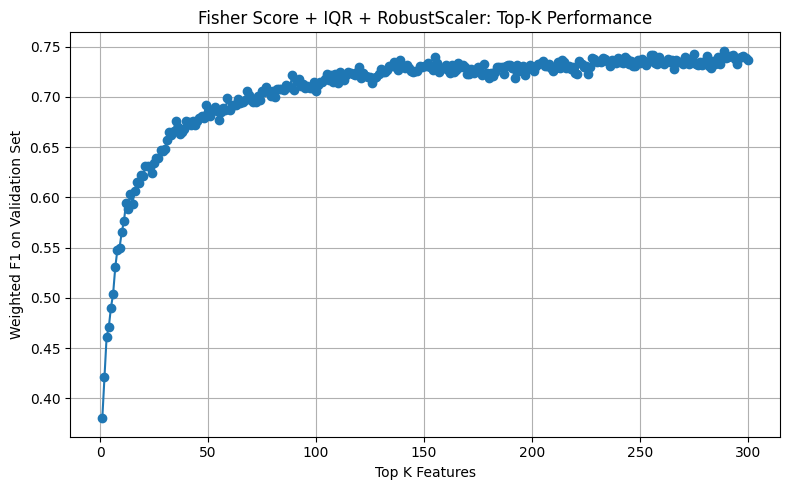


 The best k is 289, and its weighted F1-score on validation set is 0.7459


In [23]:
# === Step 0: 划分子训练集与验证集 ===
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# === Step 2: Fisher Score 实现 ===
def fisher_score(X, y):
    y = y.values.ravel()
    overall_mean = X.mean(axis=0)
    classes = np.unique(y)

    numerator = np.zeros(X.shape[1])
    denominator = np.zeros(X.shape[1])

    for cls in classes:
        idx = (y == cls)
        n_c = np.sum(idx)
        if n_c == 0:
            continue
        class_mean = X[idx].mean(axis=0)
        class_var = X[idx].var(axis=0) + 1e-8  # 避免除以0
        numerator += n_c * (class_mean - overall_mean) ** 2
        denominator += n_c * class_var

    scores = numerator / denominator
    return scores

# === Step 3: IQR + RobustScaler ===
X_train_sub_capped = winsorize_iqr(X_train_sub)
X_val_capped = winsorize_iqr(X_val)

scaler = RobustScaler()
X_train_sub_scaled = pd.DataFrame(scaler.fit_transform(X_train_sub_capped),
                                  columns=X_train_sub.columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val_capped),
                            columns=X_val.columns)

# === Step 4: Fisher Score 计算 + Top-K 特征评估 ===
k_list = list(range(1, 301))
results = []

fisher_scores = fisher_score(X_train_sub_scaled, y_train_sub)
feature_ranks = np.argsort(fisher_scores)[::-1]  # 降序排列

for k in tqdm(k_list, desc="Evaluating Top-K (Fisher Score) on Validation"):
    selected_indices = feature_ranks[:k]
    selected_cols = X_train_sub_scaled.columns[selected_indices]

    Xk_train = X_train_sub_scaled[selected_cols]
    Xk_val   = X_val_scaled[selected_cols]

    model = XGBClassifier(
        objective='multi:softprob',
        num_class=28,
        eval_metric='mlogloss',
        n_estimators=100,
        random_state=42,
        tree_method='hist',
        device='cuda'
    )
    model.fit(Xk_train, y_train_sub.values.ravel())
    y_pred = model.predict(Xk_val)

    f1 = f1_score(y_val, y_pred, average='weighted')
    results.append((k, f1))

# === Step 5: 可视化 Top-K vs 验证集 F1 ===
k_vals, f1_vals = zip(*results)
plt.figure(figsize=(8, 5))
plt.plot(k_vals, f1_vals, marker='o')
plt.xlabel("Top K Features")
plt.ylabel("Weighted F1 on Validation Set")
plt.title("Fisher Score + IQR + RobustScaler: Top-K Performance")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Step 6: 输出最优 K 和对应的验证集 F1 ===
best_k, best_f1 = max(results, key=lambda x: x[1])
print(f"\n The best k is {best_k}, and its weighted F1-score on validation set is {best_f1:.4f}")


In [7]:
# === Step 0: 划分训练子集与验证集 ===
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# === Step 1: 离群值裁剪（IQR）===
def winsorize_iqr(df, lower=1.5, upper=1.5):
    df_capped = df.copy()
    for col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - lower * IQR
        upper_bound = Q3 + upper * IQR
        df_capped[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    return df_capped

X_train_sub_capped = winsorize_iqr(X_train_sub)
X_val_capped = winsorize_iqr(X_val)

# === Step 2: 鲁棒标准化 ===
scaler = RobustScaler()
X_train_sub_scaled = pd.DataFrame(scaler.fit_transform(X_train_sub_capped), columns=X_train_sub.columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val_capped), columns=X_val.columns)

# === Step 3: 自定义 Fisher Score 函数 ===
def fisher_score_manual(X, y):
    X = np.asarray(X)
    y = np.asarray(y)
    classes = np.unique(y)
    n_features = X.shape[1]
    scores = np.zeros(n_features)

    overall_mean = X.mean(axis=0)

    for j in range(n_features):
        num = 0.0
        denom = 0.0
        for c in classes:
            X_c = X[y == c, j]
            n_c = X_c.shape[0]
            mu_c = np.mean(X_c)
            var_c = np.var(X_c)
            num += n_c * (mu_c - overall_mean[j]) ** 2
            denom += n_c * var_c
        scores[j] = num / (denom + 1e-8)  # 防止除以 0
    return scores

# === Step 4: 设置选择的特征数量 ===
k = 289

# === Step 5: 计算 Fisher Score 并选择前 k 个特征（仅用训练子集）===
fisher_scores = fisher_score_manual(X_train_sub_scaled.values, y_train_sub.values.ravel())
feature_ranks = np.argsort(fisher_scores)[::-1]
top_indices = feature_ranks[:k]
top_columns = X_train_sub_scaled.columns[top_indices]

# === Step 6: 筛选子训练集 & 验证集中的特征列 ===
X_train_fisher = X_train_sub_scaled[top_columns]
X_val_fisher = X_val_scaled[top_columns]

# === Step 7: 构造评分表输出 ===
feature_scores_df = pd.DataFrame({
    'Feature': X_train_sub_scaled.columns,
    'Fisher_Score': fisher_scores
})
top_features_df = feature_scores_df.sort_values(by='Fisher_Score', ascending=False).head(k).reset_index(drop=True)

# === Step 8: 打印结果 ===
print(f"\nTop {k} Features by Fisher Score (from validation set split):")
print(top_features_df)


Top 289 Features by Fisher Score (from validation set split):
    Feature  Fisher_Score
0        48      0.876307
1        17      0.779868
2       270      0.755886
3       263      0.747138
4        90      0.702897
..      ...           ...
284      57      0.044131
285      40      0.041735
286      42      0.040890
287     137      0.040572
288     288      0.039718

[289 rows x 2 columns]


In [8]:
# === Weighted Log Loss 实现 ===
def weighted_log_loss(y_true, y_pred_proba):
    class_counts = np.sum(y_true, axis=0)
    class_weights = 1.0 / (class_counts + 1e-8)
    class_weights /= np.sum(class_weights)

    sample_weights = np.sum(y_true * class_weights, axis=1)
    sample_losses = -np.sum(y_true * np.log(y_pred_proba + 1e-8), axis=1)
    weighted_loss = np.mean(sample_weights * sample_losses)
    return weighted_loss

# === 特征集合（训练子集 & 验证集，统一评估）===
feature_sets = {
    "IOR": (X_train_selected, X_val_selected),
    "F-test": (X_train_ftest, X_val_ftest),
    "Fisher Score": (X_train_fisher, X_val_fisher)
}

results_xgb = []

for name, (X_subtrain, X_val) in feature_sets.items():
    print(f"\n[XGBoost] Feature Selection: {name}")

    # = 1. 可选 Winsorize（如之前已处理，此步可跳过） =
    X_subtrain = winsorize_iqr(X_subtrain)
    X_val = winsorize_iqr(X_val)

    # = 2. Robust Scaling =
    scaler = RobustScaler()
    X_subtrain_scaled = scaler.fit_transform(X_subtrain)
    X_val_scaled = scaler.transform(X_val)

    # = 3. SMOTE 过采样（用于训练子集）=
    smote = SMOTE(random_state=42, k_neighbors=3)
    X_subtrain_res, y_subtrain_res = smote.fit_resample(X_subtrain_scaled, y_train_sub)

    # = 4. 训练 XGBoost 模型 =
    model = XGBClassifier(
        objective='multi:softprob',
        num_class=28,
        eval_metric='mlogloss',
        n_estimators=100,
        random_state=42,
        tree_method='hist',
        device='cuda'
    )
    model.fit(X_subtrain_res, y_subtrain_res)

    # = 5. 验证集预测 =
    y_val_pred = model.predict(X_val_scaled)
    y_val_proba = model.predict_proba(X_val_scaled)

    # = 6. One-hot 编码 y_val =
    lb = LabelBinarizer()
    lb.fit(range(28))
    y_val_onehot = lb.transform(y_val)
    if y_val_onehot.shape[1] == 1:  # 防止维度问题
        y_val_onehot = np.hstack([1 - y_val_onehot, y_val_onehot])

    # = 7. 汇总结果 =
    results_xgb.append({
        "Feature Selection": name,
        "F1_macro": round(f1_score(y_val, y_val_pred, average='macro', zero_division=0), 4),
        "F1_weighted": round(f1_score(y_val, y_val_pred, average='weighted', zero_division=0), 4),
        "Log_loss": round(log_loss(y_val, y_val_proba), 4),
        "Weighted_Log_Loss": round(weighted_log_loss(y_val_onehot, y_val_proba), 4)
    })

# === 最终评估结果表格输出 ===
df_xgb = pd.DataFrame(results_xgb)
print("\n=== XGBoost Evaluation Results on Validation Set ===")
print(df_xgb)


[XGBoost] Feature Selection: IOR


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [23:23:39] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)



[XGBoost] Feature Selection: F-test

[XGBoost] Feature Selection: Fisher Score

=== XGBoost Evaluation Results on Validation Set ===
  Feature Selection  F1_macro  F1_weighted  Log_loss  Weighted_Log_Loss
0               IOR    0.4241       0.7448    0.9971             0.0094
1            F-test    0.4138       0.7363    1.0174             0.0091
2      Fisher Score    0.4389       0.7437    0.9888             0.0091


In [26]:
# === 1. 数据准备 ===
# 假设 X_train_ftest、y_train_sub 已经定义并且为 pandas.DataFrame/Series
X_train_fs = X_train_fisher.copy()  # Fisher-Score 选择后的特征子集

# 离群值裁剪
X_train_clean = winsorize_iqr(X_train_fs)

# 缩放
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_train_clean)

# 划分子训练集和验证集（验证集用于最终评估）
X_subtrain, X_val, y_subtrain, y_val = train_test_split(
    X_scaled,
    y_train_sub,
    test_size=0.2,
    stratify=y_train_sub,
    random_state=42
)

# 对子训练集做 SMOTE 过采样
smote = SMOTE(random_state=42, k_neighbors=3)
X_subtrain_res, y_subtrain_res = smote.fit_resample(X_subtrain, y_subtrain.values.ravel())

# === 2. 定义基础模型和交叉验证方案 ===
base_model = XGBClassifier(
    objective='multi:softprob',
    num_class=28,
    eval_metric='mlogloss',
    tree_method='hist',
    device='cuda',
    random_state=42
)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# === 3. 四个阶段的参数网格列表 ===
param_grids = [
    # 第一阶段：学习率 + 基学习器数
    {
        'n_estimators': [100, 300, 500, 700, 1000],
        'learning_rate': [0.01, 0.05, 0.1, 0.3]
    },
    # 第二阶段：树深度 + 最小叶子权重
    {
        'max_depth': [3, 6, 10],
        'min_child_weight': [1, 3, 5]
    },
    # 第三阶段：样本采样比例 + 特征采样比例 + gamma
    {
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 0.1, 0.3, 0.5]
    },
    # 第四阶段：L1/L2 正则
    {
        'reg_alpha': [0, 0.5, 1],
        'reg_lambda': [1, 5, 10]
    }
]

# 用于累积各阶段的最优参数
best_params = {}

# === 4. 分阶段循环 GridSearchCV ===
for stage, grid_params in enumerate(param_grids, start=1):
    print(f"\n=== Stage {stage} Hyperparameter Tuning ===")
    # 将前面阶段的最优参数 set 给模型
    model = base_model.set_params(**best_params)
    # 构建并运行 GridSearchCV
    gs = GridSearchCV(
        estimator=model,
        param_grid=grid_params,
        scoring='f1_weighted',
        cv=cv,
        refit=True,
        verbose=2,
        n_jobs=-1
    )
    gs.fit(X_subtrain_res, y_subtrain_res)
    # 打印并累积最优参数
    print(f"Stage {stage} best parameters: {gs.best_params_}")
    best_params.update(gs.best_params_)

print("\nFour-stage cumulative optimal parameters: ", best_params)

# === 5. 用累计的最优参数训练最终模型 ===
final_model = base_model.set_params(**best_params)
final_model.fit(X_subtrain_res, y_subtrain_res)

# === 6. 在验证集上评估 ===
# 对验证集做相同的预处理
X_val_df    = pd.DataFrame(X_val, columns=X_train_fs.columns)
X_val_clean = winsorize_iqr(X_val_df)
X_val_scaled= scaler.transform(X_val_clean)

y_val_pred  = final_model.predict(X_val_scaled)
y_val_proba = final_model.predict_proba(X_val_scaled)

print("\n=== Validation Set Evaluation ===")
print(classification_report(y_val, y_val_pred, zero_division=0))
print(f"F1 Macro:    {f1_score(y_val, y_val_pred, average='macro'):.4f}")
print(f"F1 Weighted: {f1_score(y_val, y_val_pred, average='weighted'):.4f}")
print(f"Accuracy:    {accuracy_score(y_val, y_val_pred):.4f}")
print(f"Log Loss:    {log_loss(y_val, y_val_proba):.4f}")


=== Stage 1 Hyperparameter Tuning ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [15:15:18] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ...............learning_rate=0.01, n_estimators=100; total time= 3.0min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [15:15:26] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ...............learning_rate=0.01, n_estimators=100; total time= 3.1min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [15:15:28] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ...............learning_rate=0.01, n_estimators=100; total time= 3.1min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [15:15:29] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ...............learning_rate=0.01, n_estimators=100; total time= 3.1min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [15:15:30] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ...............learning_rate=0.01, n_estimators=100; total time= 3.2min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [15:21:25] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ...............learning_rate=0.01, n_estimators=300; total time= 9.1min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [15:21:28] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ...............learning_rate=0.01, n_estimators=300; total time= 9.1min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [15:21:28] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [15:21:29] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for bo

[CV] END ...............learning_rate=0.01, n_estimators=300; total time= 9.1min
[CV] END ...............learning_rate=0.01, n_estimators=300; total time= 9.1min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [15:21:30] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ...............learning_rate=0.01, n_estimators=300; total time= 9.2min
[CV] END ...............learning_rate=0.05, n_estimators=100; total time= 3.0min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [15:27:25] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ...............learning_rate=0.01, n_estimators=500; total time=15.1min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [15:27:26] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [15:27:26] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for bo

[CV] END ...............learning_rate=0.01, n_estimators=500; total time=15.1min
[CV] END ...............learning_rate=0.01, n_estimators=500; total time=15.1min
[CV] END ...............learning_rate=0.01, n_estimators=500; total time=15.1min
[CV] END ...............learning_rate=0.01, n_estimators=500; total time=15.1min
[CV] END ...............learning_rate=0.05, n_estimators=100; total time= 3.0min
[CV] END ...............learning_rate=0.05, n_estimators=100; total time= 3.0min
[CV] END ...............learning_rate=0.05, n_estimators=100; total time= 3.0min
[CV] END ...............learning_rate=0.05, n_estimators=100; total time= 3.0min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [15:33:19] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ...............learning_rate=0.01, n_estimators=700; total time=21.0min
[CV] END ...............learning_rate=0.05, n_estimators=300; total time= 8.5min
[CV] END ...............learning_rate=0.05, n_estimators=300; total time= 8.5min
[CV] END ...............learning_rate=0.05, n_estimators=300; total time= 8.5min
[CV] END ...............learning_rate=0.01, n_estimators=700; total time=20.8min


/root/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ...............learning_rate=0.01, n_estimators=700; total time=20.8min
[CV] END ...............learning_rate=0.01, n_estimators=700; total time=20.8min
[CV] END ...............learning_rate=0.01, n_estimators=700; total time=20.8min
[CV] END ...............learning_rate=0.05, n_estimators=300; total time= 8.5min
[CV] END ...............learning_rate=0.05, n_estimators=300; total time= 8.5min
[CV] END ...............learning_rate=0.05, n_estimators=500; total time=13.0min
[CV] END ..............learning_rate=0.01, n_estimators=1000; total time=29.2min
[CV] END ...............learning_rate=0.05, n_estimators=500; total time=12.8min
[CV] END ...............learning_rate=0.05, n_estimators=500; total time=12.7min
[CV] END ...............learning_rate=0.05, n_estimators=500; total time=12.7min
[CV] END ...............learning_rate=0.05, n_estimators=500; total time=12.7min
[CV] END ..............learning_rate=0.01, n_estimators=1000; total time=28.8min
[CV] END ..............learn

/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [15:52:39] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ...............learning_rate=0.05, n_estimators=700; total time=16.5min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [15:52:45] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ...............learning_rate=0.05, n_estimators=700; total time=16.5min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [15:52:48] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ...............learning_rate=0.05, n_estimators=700; total time=16.5min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [15:52:48] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ...............learning_rate=0.05, n_estimators=700; total time=16.5min
[CV] END ................learning_rate=0.1, n_estimators=100; total time= 2.8min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [15:53:02] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [15:53:02] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for bo

[CV] END ................learning_rate=0.1, n_estimators=100; total time= 2.8min
[CV] END ................learning_rate=0.1, n_estimators=100; total time= 2.8min
[CV] END ...............learning_rate=0.05, n_estimators=700; total time=16.4min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [15:57:26] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ................learning_rate=0.1, n_estimators=300; total time= 7.1min
[CV] END ................learning_rate=0.1, n_estimators=300; total time= 7.1min
[CV] END ................learning_rate=0.1, n_estimators=300; total time= 7.1min
[CV] END ................learning_rate=0.1, n_estimators=300; total time= 7.0min
[CV] END ................learning_rate=0.1, n_estimators=300; total time= 7.0min
[CV] END ..............learning_rate=0.05, n_estimators=1000; total time=21.4min
[CV] END ................learning_rate=0.1, n_estimators=500; total time=10.3min
[CV] END ................learning_rate=0.1, n_estimators=500; total time=10.3min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [16:03:15] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ................learning_rate=0.1, n_estimators=500; total time=10.3min
[CV] END ................learning_rate=0.1, n_estimators=500; total time=10.3min
[CV] END ................learning_rate=0.1, n_estimators=500; total time=10.3min
[CV] END ..............learning_rate=0.05, n_estimators=1000; total time=21.0min
[CV] END ................learning_rate=0.3, n_estimators=100; total time= 2.3min
[CV] END ................learning_rate=0.3, n_estimators=100; total time= 2.3min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [16:05:36] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ..............learning_rate=0.05, n_estimators=1000; total time=20.9min
[CV] END ................learning_rate=0.3, n_estimators=100; total time= 2.2min
[CV] END ..............learning_rate=0.05, n_estimators=1000; total time=20.8min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [16:07:49] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ................learning_rate=0.3, n_estimators=100; total time= 2.2min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [16:07:50] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ................learning_rate=0.3, n_estimators=100; total time= 2.2min
[CV] END ................learning_rate=0.1, n_estimators=700; total time=13.1min
[CV] END ..............learning_rate=0.05, n_estimators=1000; total time=20.6min
[CV] END ................learning_rate=0.1, n_estimators=700; total time=13.0min
[CV] END ................learning_rate=0.3, n_estimators=300; total time= 5.1min
[CV] END ................learning_rate=0.1, n_estimators=700; total time=12.9min
[CV] END ................learning_rate=0.1, n_estimators=700; total time=12.9min
[CV] END ................learning_rate=0.3, n_estimators=300; total time= 5.1min
[CV] END ................learning_rate=0.3, n_estimators=300; total time= 5.1min
[CV] END ................learning_rate=0.1, n_estimators=700; total time=12.9min
[CV] END ................learning_rate=0.3, n_estimators=300; total time= 5.1min
[CV] END ................learning_rate=0.3, n_estimators=300; total time= 5.1min
[CV] END ................lea

/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [16:17:54] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ................learning_rate=0.3, n_estimators=500; total time= 7.5min
[CV] END ................learning_rate=0.3, n_estimators=500; total time= 7.5min
[CV] END ................learning_rate=0.3, n_estimators=500; total time= 7.3min
[CV] END ...............learning_rate=0.1, n_estimators=1000; total time=16.4min
[CV] END ...............learning_rate=0.1, n_estimators=1000; total time=16.4min
[CV] END ...............learning_rate=0.1, n_estimators=1000; total time=16.3min
[CV] END ................learning_rate=0.3, n_estimators=700; total time= 8.9min
[CV] END ................learning_rate=0.3, n_estimators=700; total time= 8.8min
[CV] END ................learning_rate=0.3, n_estimators=700; total time= 8.6min
[CV] END ................learning_rate=0.3, n_estimators=700; total time= 8.3min
[CV] END ................learning_rate=0.3, n_estimators=700; total time= 8.1min
[CV] END ...............learning_rate=0.3, n_estimators=1000; total time= 9.1min
[CV] END ...............lear

/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [16:38:26] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [16:38:26] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for bo

[CV] END ....................max_depth=3, min_child_weight=5; total time=14.6min
[CV] END ....................max_depth=3, min_child_weight=5; total time=14.7min
[CV] END ....................max_depth=3, min_child_weight=5; total time=14.7min
[CV] END ....................max_depth=3, min_child_weight=3; total time=14.9min
[CV] END ....................max_depth=3, min_child_weight=3; total time=14.9min
[CV] END ....................max_depth=3, min_child_weight=3; total time=14.9min
[CV] END ....................max_depth=3, min_child_weight=3; total time=14.9min
[CV] END ....................max_depth=3, min_child_weight=3; total time=14.9min


/root/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ....................max_depth=3, min_child_weight=1; total time=15.2min
[CV] END ....................max_depth=3, min_child_weight=1; total time=15.2min
[CV] END ....................max_depth=3, min_child_weight=1; total time=15.2min
[CV] END ....................max_depth=3, min_child_weight=1; total time=15.2min
[CV] END ....................max_depth=3, min_child_weight=1; total time=15.2min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [16:42:35] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ....................max_depth=6, min_child_weight=1; total time=18.8min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [16:57:38] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ....................max_depth=6, min_child_weight=5; total time=19.0min
[CV] END ....................max_depth=6, min_child_weight=3; total time=19.4min
[CV] END ....................max_depth=6, min_child_weight=5; total time=19.0min
[CV] END ....................max_depth=6, min_child_weight=5; total time=19.0min
[CV] END ....................max_depth=6, min_child_weight=5; total time=19.0min
[CV] END ....................max_depth=6, min_child_weight=5; total time=19.0min
[CV] END ....................max_depth=6, min_child_weight=3; total time=19.4min
[CV] END ....................max_depth=6, min_child_weight=3; total time=19.4min
[CV] END ....................max_depth=6, min_child_weight=3; total time=19.4min
[CV] END ....................max_depth=6, min_child_weight=3; total time=19.5min
[CV] END ....................max_depth=6, min_child_weight=1; total time=20.8min
[CV] END ....................max_depth=6, min_child_weight=1; total time=20.9min
[CV] END ...................

/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [17:16:08] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ...................max_depth=10, min_child_weight=5; total time=18.1min
[CV] END ...................max_depth=10, min_child_weight=5; total time=18.1min
[CV] END ...................max_depth=10, min_child_weight=3; total time=18.4min
[CV] END ...................max_depth=10, min_child_weight=3; total time=18.5min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [17:16:24] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ...................max_depth=10, min_child_weight=3; total time=18.4min
[CV] END ...................max_depth=10, min_child_weight=3; total time=18.4min
[CV] END ...................max_depth=10, min_child_weight=3; total time=18.4min
[CV] END ...................max_depth=10, min_child_weight=5; total time=17.3min
[CV] END ...................max_depth=10, min_child_weight=5; total time=17.4min
[CV] END ...................max_depth=10, min_child_weight=1; total time=19.1min
[CV] END ...................max_depth=10, min_child_weight=1; total time=18.9min
[CV] END ...................max_depth=10, min_child_weight=1; total time=18.8min


/root/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/root/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
  File "/root/miniconda3/lib/python3.10/site-packages/xgboost/sklearn.py", line 1682, in fit
    self._Booster = train(
  File "/root/miniconda3/lib/python3.10/site-packages/xgboost/core.

Stage 2 best parameters: {'max_depth': 6, 'min_child_weight': 1}

=== Stage 3 Hyperparameter Tuning ===
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [17:35:25] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .....colsample_bytree=0.6, gamma=0.1, subsample=0.6; total time=17.7min
[CV] END .......colsample_bytree=0.6, gamma=0, subsample=0.6; total time=21.1min


/root/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END .......colsample_bytree=0.6, gamma=0, subsample=0.6; total time=21.1min
[CV] END .......colsample_bytree=0.6, gamma=0, subsample=0.6; total time=21.1min
[CV] END .......colsample_bytree=0.6, gamma=0, subsample=0.6; total time=21.1min
[CV] END .......colsample_bytree=0.6, gamma=0, subsample=0.6; total time=21.1min
[CV] END .......colsample_bytree=0.6, gamma=0, subsample=0.8; total time=21.2min
[CV] END .......colsample_bytree=0.6, gamma=0, subsample=0.8; total time=21.3min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [17:38:56] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .......colsample_bytree=0.6, gamma=0, subsample=0.8; total time=21.3min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [17:38:57] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [17:38:58] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for bo

[CV] END .......colsample_bytree=0.6, gamma=0, subsample=0.8; total time=21.3min
[CV] END .......colsample_bytree=0.6, gamma=0, subsample=0.8; total time=21.3min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [17:39:03] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .......colsample_bytree=0.6, gamma=0, subsample=1.0; total time=21.4min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [17:39:04] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [17:39:04] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for bo

[CV] END .......colsample_bytree=0.6, gamma=0, subsample=1.0; total time=21.4min
[CV] END .......colsample_bytree=0.6, gamma=0, subsample=1.0; total time=21.4min
[CV] END .......colsample_bytree=0.6, gamma=0, subsample=1.0; total time=21.4min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [17:39:05] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .......colsample_bytree=0.6, gamma=0, subsample=1.0; total time=21.4min
[CV] END .....colsample_bytree=0.6, gamma=0.1, subsample=0.6; total time=17.1min
[CV] END .....colsample_bytree=0.6, gamma=0.3, subsample=0.6; total time=15.9min
[CV] END .....colsample_bytree=0.6, gamma=0.3, subsample=0.6; total time=15.9min
[CV] END .....colsample_bytree=0.6, gamma=0.1, subsample=1.0; total time=16.3min
[CV] END .....colsample_bytree=0.6, gamma=0.1, subsample=1.0; total time=16.3min
[CV] END .....colsample_bytree=0.6, gamma=0.1, subsample=1.0; total time=16.3min
[CV] END .....colsample_bytree=0.6, gamma=0.1, subsample=1.0; total time=16.4min
[CV] END .....colsample_bytree=0.6, gamma=0.1, subsample=1.0; total time=16.3min
[CV] END .....colsample_bytree=0.6, gamma=0.1, subsample=0.8; total time=16.7min
[CV] END .....colsample_bytree=0.6, gamma=0.1, subsample=0.8; total time=16.8min
[CV] END .....colsample_bytree=0.6, gamma=0.1, subsample=0.8; total time=16.7min
[CV] END .....colsample_bytr

/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [17:55:48] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .....colsample_bytree=0.6, gamma=0.1, subsample=0.6; total time=17.0min
[CV] END .....colsample_bytree=0.6, gamma=0.3, subsample=0.6; total time=15.6min
[CV] END .....colsample_bytree=0.6, gamma=0.3, subsample=0.6; total time=15.6min
[CV] END .....colsample_bytree=0.6, gamma=0.3, subsample=0.6; total time=15.6min
[CV] END .....colsample_bytree=0.6, gamma=0.3, subsample=1.0; total time=15.2min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [18:10:46] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .....colsample_bytree=0.6, gamma=0.3, subsample=1.0; total time=15.2min
[CV] END .....colsample_bytree=0.6, gamma=0.3, subsample=0.8; total time=15.5min
[CV] END .....colsample_bytree=0.6, gamma=0.3, subsample=0.8; total time=15.5min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [18:10:52] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .....colsample_bytree=0.6, gamma=0.3, subsample=1.0; total time=15.2min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [18:10:54] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .....colsample_bytree=0.6, gamma=0.3, subsample=1.0; total time=15.2min
[CV] END .....colsample_bytree=0.6, gamma=0.3, subsample=0.8; total time=15.5min
[CV] END .....colsample_bytree=0.6, gamma=0.3, subsample=1.0; total time=15.3min
[CV] END .....colsample_bytree=0.6, gamma=0.3, subsample=0.8; total time=15.5min
[CV] END .....colsample_bytree=0.6, gamma=0.3, subsample=0.8; total time=15.5min
[CV] END .....colsample_bytree=0.6, gamma=0.5, subsample=0.6; total time=15.2min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [18:11:00] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .....colsample_bytree=0.6, gamma=0.5, subsample=0.6; total time=15.3min
[CV] END .....colsample_bytree=0.6, gamma=0.5, subsample=0.6; total time=15.2min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [18:23:38] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .....colsample_bytree=0.6, gamma=0.5, subsample=0.6; total time=15.5min
[CV] END .....colsample_bytree=0.6, gamma=0.5, subsample=0.8; total time=15.5min
[CV] END .....colsample_bytree=0.6, gamma=0.5, subsample=0.6; total time=15.6min
[CV] END .....colsample_bytree=0.6, gamma=0.5, subsample=1.0; total time=15.3min
[CV] END .....colsample_bytree=0.6, gamma=0.5, subsample=1.0; total time=15.3min
[CV] END .....colsample_bytree=0.6, gamma=0.5, subsample=1.0; total time=15.3min
[CV] END .....colsample_bytree=0.6, gamma=0.5, subsample=1.0; total time=15.3min
[CV] END .....colsample_bytree=0.6, gamma=0.5, subsample=1.0; total time=15.3min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [18:26:17] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .....colsample_bytree=0.6, gamma=0.5, subsample=0.8; total time=15.5min
[CV] END .....colsample_bytree=0.6, gamma=0.5, subsample=0.8; total time=15.5min
[CV] END .....colsample_bytree=0.6, gamma=0.5, subsample=0.8; total time=15.5min
[CV] END .....colsample_bytree=0.6, gamma=0.5, subsample=0.8; total time=15.5min
[CV] END .......colsample_bytree=0.8, gamma=0, subsample=0.6; total time=20.9min
[CV] END .......colsample_bytree=0.8, gamma=0, subsample=0.6; total time=20.9min
[CV] END .......colsample_bytree=0.8, gamma=0, subsample=0.6; total time=20.9min
[CV] END .......colsample_bytree=0.8, gamma=0, subsample=0.6; total time=20.9min
[CV] END .....colsample_bytree=0.8, gamma=0.1, subsample=0.6; total time=17.7min
[CV] END .......colsample_bytree=0.8, gamma=0, subsample=0.6; total time=21.1min
[CV] END .......colsample_bytree=0.8, gamma=0, subsample=0.8; total time=21.3min
[CV] END .......colsample_bytree=0.8, gamma=0, subsample=0.8; total time=21.2min
[CV] END .......colsample_by

/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [18:49:07] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .....colsample_bytree=0.8, gamma=0.1, subsample=0.6; total time=17.3min
[CV] END .....colsample_bytree=0.8, gamma=0.1, subsample=0.6; total time=17.2min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [18:49:13] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .....colsample_bytree=0.8, gamma=0.1, subsample=0.6; total time=17.3min
[CV] END .....colsample_bytree=0.8, gamma=0.1, subsample=0.8; total time=16.9min
[CV] END .....colsample_bytree=0.8, gamma=0.1, subsample=0.8; total time=16.8min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [19:03:38] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .....colsample_bytree=0.8, gamma=0.3, subsample=0.6; total time=16.0min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [19:03:40] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .....colsample_bytree=0.8, gamma=0.3, subsample=0.6; total time=16.0min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [19:03:53] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [19:03:53] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for bo

[CV] END .....colsample_bytree=0.8, gamma=0.1, subsample=1.0; total time=16.5min
[CV] END .....colsample_bytree=0.8, gamma=0.1, subsample=1.0; total time=16.4min
[CV] END .....colsample_bytree=0.8, gamma=0.1, subsample=1.0; total time=16.5min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [19:04:01] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .....colsample_bytree=0.8, gamma=0.1, subsample=1.0; total time=16.5min
[CV] END .....colsample_bytree=0.8, gamma=0.1, subsample=1.0; total time=16.5min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [19:04:09] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .....colsample_bytree=0.8, gamma=0.1, subsample=0.8; total time=16.8min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [19:04:12] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .....colsample_bytree=0.8, gamma=0.1, subsample=0.8; total time=16.8min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [19:04:15] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .....colsample_bytree=0.8, gamma=0.1, subsample=0.8; total time=16.8min
[CV] END .....colsample_bytree=0.8, gamma=0.3, subsample=0.6; total time=15.9min
[CV] END .....colsample_bytree=0.8, gamma=0.3, subsample=0.8; total time=15.8min
[CV] END .....colsample_bytree=0.8, gamma=0.3, subsample=0.6; total time=15.9min
[CV] END .....colsample_bytree=0.8, gamma=0.3, subsample=0.6; total time=15.9min
[CV] END .....colsample_bytree=0.8, gamma=0.3, subsample=0.8; total time=15.6min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [19:17:14] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .....colsample_bytree=0.8, gamma=0.3, subsample=0.8; total time=15.6min
[CV] END .....colsample_bytree=0.8, gamma=0.3, subsample=0.8; total time=15.6min
[CV] END .....colsample_bytree=0.8, gamma=0.3, subsample=1.0; total time=15.4min
[CV] END .....colsample_bytree=0.8, gamma=0.3, subsample=1.0; total time=15.4min
[CV] END .....colsample_bytree=0.8, gamma=0.3, subsample=0.8; total time=15.6min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [19:19:24] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .....colsample_bytree=0.8, gamma=0.3, subsample=1.0; total time=15.4min
[CV] END .....colsample_bytree=0.8, gamma=0.3, subsample=1.0; total time=15.4min
[CV] END .....colsample_bytree=0.8, gamma=0.3, subsample=1.0; total time=15.4min
[CV] END .....colsample_bytree=0.8, gamma=0.5, subsample=0.6; total time=15.4min
[CV] END .....colsample_bytree=0.8, gamma=0.5, subsample=0.6; total time=15.4min
[CV] END .....colsample_bytree=0.8, gamma=0.5, subsample=0.6; total time=15.4min
[CV] END .....colsample_bytree=0.8, gamma=0.5, subsample=0.8; total time=15.3min
[CV] END .....colsample_bytree=0.8, gamma=0.5, subsample=0.6; total time=15.4min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [19:20:24] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .....colsample_bytree=0.8, gamma=0.5, subsample=0.8; total time=15.3min
[CV] END .....colsample_bytree=0.8, gamma=0.5, subsample=0.6; total time=15.4min
[CV] END .....colsample_bytree=0.8, gamma=0.5, subsample=0.8; total time=16.2min
[CV] END .....colsample_bytree=0.8, gamma=0.5, subsample=0.8; total time=16.3min
[CV] END .....colsample_bytree=0.8, gamma=0.5, subsample=1.0; total time=16.3min
[CV] END .....colsample_bytree=0.8, gamma=0.5, subsample=1.0; total time=16.3min
[CV] END .....colsample_bytree=0.8, gamma=0.5, subsample=1.0; total time=16.3min
[CV] END .....colsample_bytree=0.8, gamma=0.5, subsample=1.0; total time=16.3min
[CV] END .....colsample_bytree=0.8, gamma=0.5, subsample=1.0; total time=16.3min
[CV] END .....colsample_bytree=0.8, gamma=0.5, subsample=0.8; total time=16.5min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [19:38:38] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .......colsample_bytree=1.0, gamma=0, subsample=0.6; total time=19.1min
[CV] END .......colsample_bytree=1.0, gamma=0, subsample=0.6; total time=19.1min
[CV] END .......colsample_bytree=1.0, gamma=0, subsample=0.6; total time=19.1min
[CV] END .......colsample_bytree=1.0, gamma=0, subsample=0.6; total time=19.1min
[CV] END .......colsample_bytree=1.0, gamma=0, subsample=0.6; total time=19.2min
[CV] END .......colsample_bytree=1.0, gamma=0, subsample=0.8; total time=19.3min
[CV] END .......colsample_bytree=1.0, gamma=0, subsample=0.8; total time=19.3min
[CV] END .......colsample_bytree=1.0, gamma=0, subsample=0.8; total time=19.3min
[CV] END .....colsample_bytree=1.0, gamma=0.1, subsample=0.6; total time=16.0min
[CV] END .......colsample_bytree=1.0, gamma=0, subsample=0.8; total time=19.7min
[CV] END .......colsample_bytree=1.0, gamma=0, subsample=0.8; total time=19.8min
[CV] END .....colsample_bytree=1.0, gamma=0.1, subsample=0.6; total time=15.8min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [19:54:28] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .....colsample_bytree=1.0, gamma=0.1, subsample=0.6; total time=15.8min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [19:54:31] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .....colsample_bytree=1.0, gamma=0.1, subsample=0.6; total time=15.8min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [19:54:34] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .....colsample_bytree=1.0, gamma=0.1, subsample=0.6; total time=15.8min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [19:55:01] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .....colsample_bytree=1.0, gamma=0.1, subsample=0.8; total time=15.5min
[CV] END .....colsample_bytree=1.0, gamma=0.1, subsample=0.8; total time=15.5min
[CV] END .....colsample_bytree=1.0, gamma=0.1, subsample=0.8; total time=15.5min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [19:55:12] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .....colsample_bytree=1.0, gamma=0.1, subsample=0.8; total time=15.5min
[CV] END .......colsample_bytree=1.0, gamma=0, subsample=1.0; total time=20.1min
[CV] END .......colsample_bytree=1.0, gamma=0, subsample=1.0; total time=20.1min
[CV] END .......colsample_bytree=1.0, gamma=0, subsample=1.0; total time=20.1min
[CV] END .......colsample_bytree=1.0, gamma=0, subsample=1.0; total time=20.1min
[CV] END .......colsample_bytree=1.0, gamma=0, subsample=1.0; total time=20.1min
[CV] END .....colsample_bytree=1.0, gamma=0.1, subsample=0.8; total time=15.4min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [20:07:33] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .....colsample_bytree=1.0, gamma=0.1, subsample=1.0; total time=15.1min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [20:08:23] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .....colsample_bytree=1.0, gamma=0.1, subsample=1.0; total time=15.1min
[CV] END .....colsample_bytree=1.0, gamma=0.3, subsample=0.6; total time=14.5min
[CV] END .....colsample_bytree=1.0, gamma=0.1, subsample=1.0; total time=15.0min
[CV] END .....colsample_bytree=1.0, gamma=0.3, subsample=0.6; total time=14.5min
[CV] END .....colsample_bytree=1.0, gamma=0.1, subsample=1.0; total time=15.1min
[CV] END .....colsample_bytree=1.0, gamma=0.1, subsample=1.0; total time=15.1min
[CV] END .....colsample_bytree=1.0, gamma=0.3, subsample=0.6; total time=14.5min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [20:09:40] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .....colsample_bytree=1.0, gamma=0.3, subsample=0.6; total time=14.5min
[CV] END .....colsample_bytree=1.0, gamma=0.3, subsample=0.6; total time=14.5min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [20:10:01] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .....colsample_bytree=1.0, gamma=0.3, subsample=0.8; total time=14.4min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [20:10:01] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .....colsample_bytree=1.0, gamma=0.3, subsample=0.8; total time=14.4min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [20:10:04] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .....colsample_bytree=1.0, gamma=0.3, subsample=0.8; total time=14.4min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [20:10:12] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .....colsample_bytree=1.0, gamma=0.3, subsample=0.8; total time=14.3min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [20:10:15] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .....colsample_bytree=1.0, gamma=0.3, subsample=0.8; total time=14.3min
[CV] END .....colsample_bytree=1.0, gamma=0.3, subsample=1.0; total time=14.0min
[CV] END .....colsample_bytree=1.0, gamma=0.3, subsample=1.0; total time=14.0min
[CV] END .....colsample_bytree=1.0, gamma=0.3, subsample=1.0; total time=14.0min
[CV] END .....colsample_bytree=1.0, gamma=0.3, subsample=1.0; total time=14.0min
[CV] END .....colsample_bytree=1.0, gamma=0.3, subsample=1.0; total time=14.0min
[CV] END .....colsample_bytree=1.0, gamma=0.5, subsample=0.6; total time=14.0min
[CV] END .....colsample_bytree=1.0, gamma=0.5, subsample=0.6; total time=14.0min
[CV] END .....colsample_bytree=1.0, gamma=0.5, subsample=0.6; total time=13.9min
[CV] END .....colsample_bytree=1.0, gamma=0.5, subsample=0.6; total time=13.9min
[CV] END .....colsample_bytree=1.0, gamma=0.5, subsample=0.8; total time=13.8min
[CV] END .....colsample_bytree=1.0, gamma=0.5, subsample=0.6; total time=13.9min
[CV] END .....colsample_bytr

/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [20:26:19] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .....colsample_bytree=1.0, gamma=0.5, subsample=1.0; total time= 5.2min
[CV] END .....colsample_bytree=1.0, gamma=0.5, subsample=1.0; total time= 4.8min
[CV] END .....colsample_bytree=1.0, gamma=0.5, subsample=1.0; total time= 4.1min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [20:26:31] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .....colsample_bytree=1.0, gamma=0.5, subsample=1.0; total time= 3.4min
Stage 3 best parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'subsample': 0.6}

=== Stage 4 Hyperparameter Tuning ===
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ........................reg_alpha=0.5, reg_lambda=1; total time=21.8min
[CV] END ..........................reg_alpha=0, reg_lambda=1; total time=21.8min


/root/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ..........................reg_alpha=0, reg_lambda=1; total time=21.9min
[CV] END ..........................reg_alpha=0, reg_lambda=1; total time=21.9min
[CV] END ..........................reg_alpha=0, reg_lambda=1; total time=21.9min
[CV] END ..........................reg_alpha=0, reg_lambda=1; total time=21.9min
[CV] END ..........................reg_alpha=0, reg_lambda=5; total time=23.6min
[CV] END ..........................reg_alpha=0, reg_lambda=5; total time=23.7min
[CV] END ..........................reg_alpha=0, reg_lambda=5; total time=23.7min
[CV] END ..........................reg_alpha=0, reg_lambda=5; total time=23.7min
[CV] END ..........................reg_alpha=0, reg_lambda=5; total time=23.7min
[CV] END .........................reg_alpha=0, reg_lambda=10; total time=24.7min
[CV] END .........................reg_alpha=0, reg_lambda=10; total time=24.7min
[CV] END .........................reg_alpha=0, reg_lambda=10; total time=24.7min
[CV] END ...................

/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [21:11:11] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ........................reg_alpha=0.5, reg_lambda=1; total time=22.0min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [21:11:13] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ........................reg_alpha=0.5, reg_lambda=1; total time=22.1min
[CV] END ........................reg_alpha=0.5, reg_lambda=1; total time=22.0min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [21:11:18] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ........................reg_alpha=0.5, reg_lambda=1; total time=22.1min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [21:13:02] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [21:13:02] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for bo

[CV] END ..........................reg_alpha=1, reg_lambda=1; total time=20.9min
[CV] END ..........................reg_alpha=1, reg_lambda=1; total time=20.9min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [21:13:30] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [21:13:30] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for bo

[CV] END ........................reg_alpha=0.5, reg_lambda=5; total time=24.2min
[CV] END ........................reg_alpha=0.5, reg_lambda=5; total time=24.3min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [21:15:19] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ........................reg_alpha=0.5, reg_lambda=5; total time=24.3min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [21:15:21] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ........................reg_alpha=0.5, reg_lambda=5; total time=24.3min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [21:15:22] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ........................reg_alpha=0.5, reg_lambda=5; total time=24.3min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [21:16:39] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .......................reg_alpha=0.5, reg_lambda=10; total time=25.6min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [21:16:40] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .......................reg_alpha=0.5, reg_lambda=10; total time=25.6min
[CV] END .......................reg_alpha=0.5, reg_lambda=10; total time=25.6min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [21:17:40] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .......................reg_alpha=0.5, reg_lambda=10; total time=25.6min


/root/miniconda3/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [21:17:41] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END .......................reg_alpha=0.5, reg_lambda=10; total time=25.6min
[CV] END ..........................reg_alpha=1, reg_lambda=1; total time=18.1min
[CV] END ..........................reg_alpha=1, reg_lambda=1; total time=18.1min
[CV] END ..........................reg_alpha=1, reg_lambda=1; total time=18.1min
[CV] END ..........................reg_alpha=1, reg_lambda=5; total time=19.1min
[CV] END ..........................reg_alpha=1, reg_lambda=5; total time=18.3min
[CV] END ..........................reg_alpha=1, reg_lambda=5; total time=18.3min
[CV] END ..........................reg_alpha=1, reg_lambda=5; total time=18.0min
[CV] END ..........................reg_alpha=1, reg_lambda=5; total time=18.0min
[CV] END .........................reg_alpha=1, reg_lambda=10; total time=17.1min
[CV] END .........................reg_alpha=1, reg_lambda=10; total time=17.1min
[CV] END .........................reg_alpha=1, reg_lambda=10; total time=17.1min
[CV] END ...................


=== Validation Set Evaluation ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2
           3       0.60      0.46      0.52        13
           4       0.51      0.53      0.52        49
           5       0.90      0.96      0.93       898
           6       0.89      0.95      0.92       111
           7       0.62      0.42      0.50        24
           8       0.70      0.81      0.75       109
           9       0.00      0.00      0.00         6
          10       0.76      0.86      0.81       217
          11       0.72      0.76      0.74        17
          12       0.54      0.63      0.58       100
          13       0.50      0.08      0.13        13
          14       0.05      0.02      0.03        54
          15       1.00      0.60      0.75         5
          16       0.00      0.00      0.00   

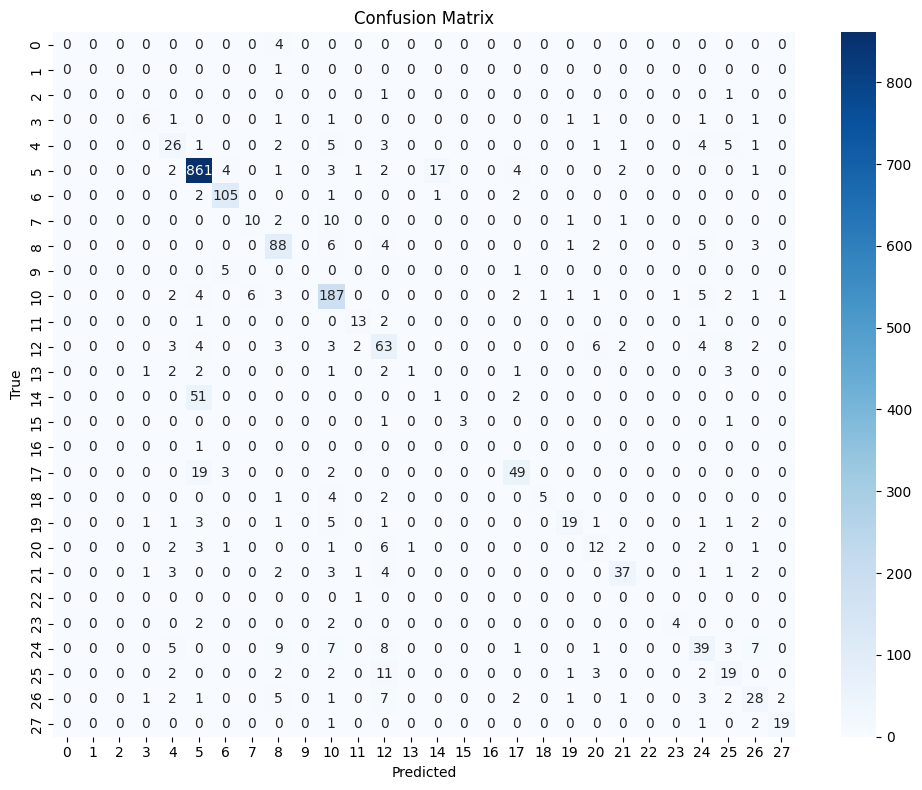

In [ ]:
# === 1. IQR 离群值裁剪 ===
def winsorize_iqr(df, lower=1.5, upper=1.5):
    df_capped = df.copy()
    for col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df_capped[col] = df[col].clip(
            lower=Q1 - lower * IQR,
            upper=Q3 + upper * IQR
        )
    return df_capped

# === 2. 加权 Log Loss ===
def weighted_log_loss(y_true, y_pred_proba):
    class_counts  = np.sum(y_true, axis=0)
    class_weights = 1.0 / (class_counts + 1e-8)
    class_weights /= np.sum(class_weights)
    sample_w      = np.sum(y_true * class_weights, axis=1)
    sample_losses = -np.sum(y_true * np.log(y_pred_proba + 1e-8), axis=1)
    return np.mean(sample_w * sample_losses)

# === 3. 假定已在环境中定义：
#    X_train_fisher (pd.DataFrame), X_val_fisher (pd.DataFrame),
#    y_train_sub (pd.Series or np.array), y_val (pd.Series or np.array)

# === 4. 预处理：IQR + RobustScaler ===
X_tr_iqr    = winsorize_iqr(X_train_fisher)
X_val_iqr   = winsorize_iqr(X_val_fisher)

scaler      = RobustScaler().fit(X_tr_iqr)
X_tr_scaled = scaler.transform(X_tr_iqr)
X_val_scaled= scaler.transform(X_val_iqr)

# === 5. SMOTE 过采样（仅对训练集） ===
smote             = SMOTE(random_state=42, k_neighbors=3)
X_tr_res, y_tr_res = smote.fit_resample(
    X_tr_scaled,
    y_train_sub.values.ravel()   # 或者 y_train_sub.to_numpy().ravel()
)

# === 6. 定义并训练最终 XGBoost 模型 ===
final_model = XGBClassifier(
    objective='multi:softprob',
    num_class=28,
    eval_metric='mlogloss',
    tree_method='hist',
    device='cuda',
    random_state=42,
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=1,
    colsample_bytree=0.8,
    subsample=0.6,
    gamma=0,
    reg_alpha=0,
    reg_lambda=1
)
final_model.fit(X_tr_res, y_tr_res)

# === 7. 验证集评估 ===
y_pred   = final_model.predict(X_val_scaled)
y_proba  = final_model.predict_proba(X_val_scaled)

print("\n=== Validation Set Evaluation ===")
print(classification_report(y_val, y_pred, zero_division=0))
print(f"Accuracy:    {accuracy_score(y_val, y_pred):.4f}")
print(f"F1 Macro:    {f1_score(y_val, y_pred, average='macro'):.4f}")
print(f"F1 Weighted: {f1_score(y_val, y_pred, average='weighted'):.4f}")
print(f"Log Loss:    {log_loss(y_val, y_proba):.4f}")

# === 8. 加权 Log Loss ===
lb = LabelBinarizer().fit(range(final_model.n_classes_))
y_val_onehot = lb.transform(y_val)
if y_val_onehot.shape[1] == 1:
    y_val_onehot = np.hstack([1 - y_val_onehot, y_val_onehot])

print(f"Weighted Log Loss: {weighted_log_loss(y_val_onehot, y_proba):.4f}")

# === 9. 绘制混淆矩阵 ===
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# === 10. 保存模型 ===
final_model.save_model('final_model_2.json')


=== Final Model Evaluation ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2
           3       0.50      0.31      0.38        13
           4       0.52      0.57      0.54        49
           5       0.90      0.96      0.93       898
           6       0.89      0.95      0.92       111
           7       0.59      0.42      0.49        24
           8       0.72      0.82      0.77       109
           9       0.00      0.00      0.00         6
          10       0.77      0.86      0.81       217
          11       0.75      0.71      0.73        17
          12       0.52      0.61      0.56       100
          13       1.00      0.08      0.14        13
          14       0.11      0.04      0.06        54
          15       0.80      0.80      0.80         5
          16       0.00      0.00      0.00      

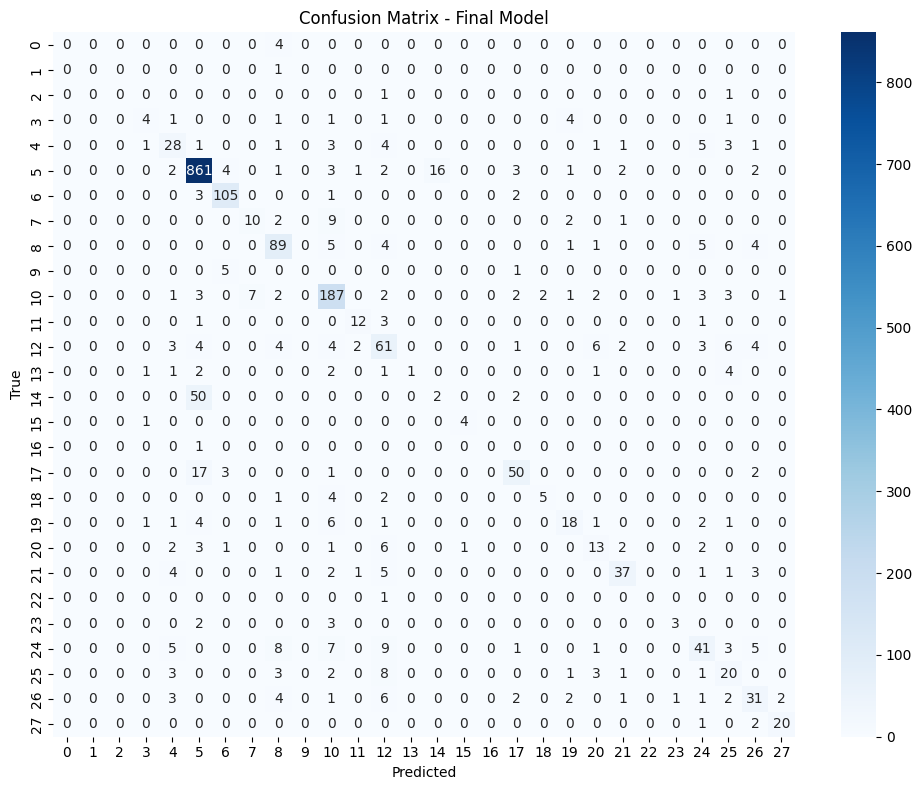

In [11]:
# === 已定义：winsorize_iqr, weighted_log_loss,
#    X_train_fisher, X_val_fisher, y_train_sub, y_val ===

# 1. 预处理：IQR + 缩放
X_tr_iqr    = winsorize_iqr(X_train_fisher)
X_val_iqr   = winsorize_iqr(X_val_fisher)

scaler      = RobustScaler().fit(X_tr_iqr)
X_tr_scaled = scaler.transform(X_tr_iqr)
X_val_scaled= scaler.transform(X_val_iqr)

# 2. SMOTE 过采样
smote             = SMOTE(random_state=42, k_neighbors=3)
X_tr_res, y_tr_res = smote.fit_resample(
    X_tr_scaled,
    y_train_sub.values.ravel()
)

# 3. 协变量偏移：训练领域分类器
X_domain = np.vstack([X_tr_scaled, X_val_scaled])
y_domain = np.array([0]*len(X_tr_scaled) + [1]*len(X_val_scaled))
domain_clf = LogisticRegression(max_iter=1000).fit(X_domain, y_domain)

# 在 resampled 训练集上估计权重
p_test  = domain_clf.predict_proba(X_tr_res)[:,1]
p_train = 1 - p_test
importance_weights = p_test / (p_train + 1e-6)

# 4. 用协变量偏移权重和原标签训练初始模型
best_params = {
    'objective':'multi:softprob','num_class':28,'eval_metric':'mlogloss',
    'tree_method':'hist','device':'cuda','random_state':42,
    'n_estimators':1000,'learning_rate':0.05,'max_depth':6,
    'min_child_weight':1,'colsample_bytree':0.8,
    'subsample':0.6,'gamma':0,'reg_alpha':0,'reg_lambda':1
}
model_cov = XGBClassifier(**best_params)
model_cov.fit(X_tr_res, y_tr_res, sample_weight=importance_weights)

# 5. 标签偏移：估计混淆矩阵 & 测试先验
def estimate_confusion_matrix(model, X, y, num_classes):
    pred = model.predict(X)
    cm   = confusion_matrix(y, pred, labels=range(num_classes))
    cm_n = cm / cm.sum(axis=1, keepdims=True)
    return np.nan_to_num(cm_n).T

# 划分一小部分训练集作“基准”验证
from sklearn.model_selection import train_test_split
X_base, X_unused, y_base, y_unused = train_test_split(
    X_tr_res, y_tr_res, test_size=0.8,
    stratify=y_tr_res, random_state=42
)

C_T          = estimate_confusion_matrix(model_cov, X_base, y_base, 28)
avg_test_pred= model_cov.predict_proba(X_val_scaled).mean(axis=0)
q_test       = np.linalg.lstsq(C_T, avg_test_pred, rcond=None)[0]
q_test       = np.clip(q_test, 0, 1)
q_test      /= q_test.sum()

train_prior  = pd.Series(y_tr_res).value_counts(normalize=True).sort_index().values

# 6. 调整训练标签
def adjust_labels(model, X, test_priors, train_priors):
    proba = model.predict_proba(X)
    ratio = test_priors / (train_priors + 1e-8)
    adj   = proba * ratio[np.newaxis,:]
    adj  /= adj.sum(axis=1, keepdims=True)
    return np.argmax(adj, axis=1)

y_tr_adjusted = adjust_labels(model_cov, X_tr_res, q_test, train_prior)

# 7. 用协变量权重 + 调整后标签 训练最终模型
model_final = XGBClassifier(**best_params)
model_final.fit(X_tr_res, y_tr_adjusted, sample_weight=importance_weights)

# 8. 在验证集上评估
y_pred  = model_final.predict(X_val_scaled)
y_proba = model_final.predict_proba(X_val_scaled)

print("\n=== Final Model Evaluation ===")
print(classification_report(y_val, y_pred, zero_division=0))
print(f"Accuracy:    {accuracy_score(y_val, y_pred):.4f}")
print(f"F1 Macro:    {f1_score(y_val, y_pred, average='macro'):.4f}")
print(f"F1 Weighted: {f1_score(y_val, y_pred, average='weighted'):.4f}")
print(f"Log Loss:    {log_loss(y_val, y_proba):.4f}")

lb = LabelBinarizer().fit(range(model_final.n_classes_))
y_val_oh = lb.transform(y_val)
if y_val_oh.shape[1]==1:
    y_val_oh = np.hstack([1-y_val_oh, y_val_oh])
print(f"Weighted Log Loss: {weighted_log_loss(y_val_oh, y_proba):.4f}")

cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Final Model')
plt.tight_layout()
plt.show()

# 9. 保存最终模型
model_final.save_model('final_model_2.json')